# Implementation #

In [21]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Read in all data into a pandas DataFrame # 

In [22]:
dfs = []

for file in glob.glob("*.csv"):
    dfs.append(pd.read_csv(file))
    print(file)
    
df = pd.concat(dfs)

df = df.reset_index()
df.columns = df.iloc[0]
df = df.set_index("Date")
#df = pd.read_csv("Poloniex_DASHBTC_1h.csv")

df["Close"] = pd.to_numeric(df["Close"], errors='coerce')
df = df.dropna()

Poloniex_DASHBTC_1h.csv
Poloniex_ETCBTC_1h.csv
Poloniex_ETHBTC_1h.csv
Poloniex_LSKBTC_1h.csv
Poloniex_LTCBTC_1h.csv
Poloniex_NXTBTC_1h.csv
Poloniex_POTBTC_1h.csv
Poloniex_XEMBTC_1h.csv
Poloniex_XMRBTC_1h.csv
Poloniex_XRPBTC_1h.csv


In [23]:
#Only keep the columns we need
df = df[['Symbol','High','Low','Close']]

df["Symbol"].drop_duplicates()


Date
2018-07-15 02-PM    DASHBTC
2018-07-15 02-PM     ETCBTC
2018-07-15 02-PM     ETHBTC
2018-07-15 02-PM     LSKBTC
2018-07-15 02-PM     LTCBTC
2018-07-15 02-PM     NXTBTC
2018-07-15 02-PM     POTBTC
2018-07-15 02-PM     XEMBTC
2018-07-15 02-PM     XMRBTC
2018-07-15 02-PM     XRPBTC
Name: Symbol, dtype: object

# Generate SMA #

In [69]:
# Initialize the short and long windows
short_window = 50
long_window = 300

relevant_df = df.loc[df["Symbol"] == 'ETHBTC']
dash_BTC = relevant_df[["Close"]].sort_index()

dash_BTC["signal"] = 0.0

dash_BTC['short_mavg'] = dash_BTC['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
dash_BTC['long_mavg'] = dash_BTC['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

dash_BTC['signal'][short_window:] = np.where(dash_BTC['short_mavg'][short_window:] 
                                            > dash_BTC['long_mavg'][short_window:], 1.0, 0.0)

dash_BTC['positions'] = dash_BTC['signal'].diff()

In [76]:
y_train = dash_BTC['signal'][51:-500]
print(y_train.shape)

#dash_BTC['Close'].plot()

(8544,)


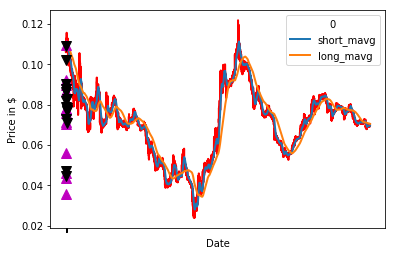

Index(['2017-07-04 10-PM', '2017-07-21 07-PM', '2017-08-13 05-PM',
       '2017-09-03 02-AM', '2017-09-28 11-PM', '2017-11-17 04-PM',
       '2017-11-29 08-AM', '2018-01-20 11-PM', '2018-02-05 11-AM',
       '2018-02-27 03-PM', '2018-03-12 07-AM', '2018-05-23 01-AM',
       '2018-06-11 08-PM', '2018-06-23 11-PM', '2018-07-10 07-AM'],
      dtype='object', name='Date')

In [71]:
fig = plt.figure()

ax1 = fig.add_subplot(111,  ylabel='Price in $')
dash_BTC['Close'].plot(ax=ax1, color='r', lw=2.)
dash_BTC[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(dash_BTC.loc[dash_BTC.positions == 1.0].index, 
         dash_BTC.short_mavg[dash_BTC.positions == 1.0],
         '^', markersize=10, color='m')

ax1.plot(dash_BTC.loc[dash_BTC.positions == -1.0].index, 
         dash_BTC.short_mavg[dash_BTC.positions == -1.0].values,
         'v', markersize=10, color='k')

plt.show()
dash_BTC.loc[dash_BTC.positions == -1.0].index

In [54]:
# Set the initial capital
initial_capital= float(100.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=dash_BTC.index).fillna(0.0)

# Buy a 100 shares
positions['dash_BTC'] = 100*dash_BTC['signal']   

# Initialize the portfolio with value owned   
portfolio = positions.multiply(dash_BTC['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(dash_BTC['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(dash_BTC['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

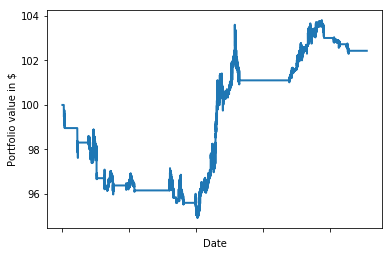

In [55]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)


# Show the plot
plt.show()

In [24]:
#Create 3D tensor
def generate_3D_tensor(df, time_index, value_selector = 'Close'):
    
    #Collect only the first 50 times 
    relevant_df = df.loc[time_index]
    close_df = relevant_df[["Symbol",value_selector]].sort_index()

    #Generate the dataframes in the shape we need
    close_df = close_df.pivot(columns='Symbol', values=value_selector).T

    #Generate 3D Tensor
    close = close_df.values

    full = close.astype('float64')
    full = torch.from_numpy(full)
    
    return full

In [25]:
full_times_index = df.index.drop_duplicates().sort_values()
full_tensor = generate_3D_tensor(df,full_times_index,'Close')


torch.Size([9095])


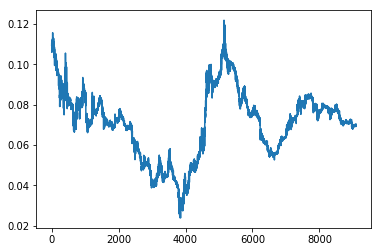

In [34]:
close_tensor = generate_3D_tensor(df,full_times_index,'Close')
high_tensor = generate_3D_tensor(df,full_times_index,'High')

stock_selector = 2

full_tensor = torch.stack((close_tensor[stock_selector,:],high_tensor[stock_selector,:]),dim=1)
print(full_tensor[:,0].shape)

plt.plot(full_tensor[:,0].numpy())

torch.Size([8544, 2, 50])
torch.Size([8544])


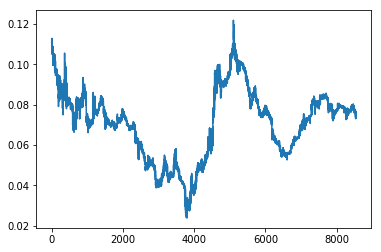

In [52]:
x_list = []
y_list = []
a = 0

import math
for i in range(math.floor(full_tensor.shape[0]-51)):
    x_list.append(full_tensor[i:i+50,:])
    #y_train.append(torch.tensor([full_tensor[2,i+51] > full_tensor[2,i+50],full_tensor[2,i+51] < full_tensor[2,i+50]]))
    y_list.append((full_tensor[i+50,0] > full_tensor[i+49,0]))
    
    
x_train = torch.stack(x_list).float()[:-500,:].permute(0,2,1)
#y_train = torch.stack(y_list).long()[:-500]

print(x_train.shape)
print(y_train.shape)

x_test = torch.stack(x_list).float()[-500:,:].permute(0,2,1)
#y_test = torch.stack(y_list).long()[-500:]


plot_x = [i[0,-1] for i in x_train]
plt.plot(plot_x)

In [28]:
class Net(nn.Module):
    
    ''' 
    Input:
    torch tensor of size (1 x 2 x 50)
                    (batch size, no of layers, input)
    '''
    
    

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv1d(2, 6, 10)
        self.conv2 = nn.Conv1d(6, 16, 10)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(80, 120)     #Remember to change this based on the input layer dimensions!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv1d(2, 6, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(6, 16, kernel_size=(10,), stride=(1,))
  (fc1): Linear(in_features=80, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


##### This could be a convenient way of getting the output dimensions of the flat input to the NN #####

In [30]:
c1 = nn.Conv1d(2, 6, 10)
c2 = nn.Conv1d(6, 16, 10)

input = F.max_pool1d(F.relu(c1(torch.randn(4,2,50))), 2)
# If the size is a square you can only specify a single number
input = F.max_pool1d(F.relu(c2(input)), 2)

net.num_flat_features(input)

80

In [31]:
import torch.optim as optim

#Define loss function and optimizer (SGD with momentum)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [55]:
loss_score = []



for epoch in range(4):
    
    running_loss = 0.0
    
    test_x = []
    test_y = []
    
    #send in batches of 4
    for i in range(math.floor(x_train.shape[0]/4)):
        test_x.append(x_train[i*4,:])
        test_y.append(y_train[i*4])
        inputs = x_train[i*4:(i+1)*4,:]
        labels = y_train[i*4:(i+1)*4]
                
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        loss_score.append(loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        

C:\Program Files\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 0.693
[2,  2000] loss: 0.693
[3,  2000] loss: 0.693
[4,  2000] loss: 0.693


tensor(0.1121)
2136
2136
tensor(0)


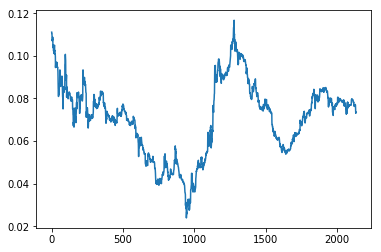

In [56]:
print(test_x[0][1,-1])
print(len(test_x))
plot_x = [test_x[i][0,-1] for i in range(len(test_x))]
print(len(test_y))
print(test_y[100])

plot_y = [test_y[i] for i in range(len(test_y))]

plt.plot(plot_x)
#plt.plot(plot_y)


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for i in range(math.floor(500/4)):
        images = x_test[i*4:(i+1)*4,:]
        labels = y_test[i*4:(i+1)*4]
        
        labels = labels.long()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 48 %
